In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load datasets
df = pd.read_csv('/content/drive/MyDrive/Combined_dataa (1).xls')

# Check the column names in the DataFrame
print(df.columns)

# Check unique values in the 'label' column
print(df['label'].unique())




# Split into features and labels
X = df['final_news']
y = df['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['Unnamed: 0', 'label', 'final_news'], dtype='object')
[1 0]


In [14]:
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
else:
    print("Column 'Unnamed: 0' not found.")

In [15]:
df.head()

,label,final_news
0,1,house dem aide didn t even see comey s letter...
1,0,flynn hillary clinton big woman campus bre...
2,1,truth might get fired truth might get fired oc...
3,1,civilians killed single us airstrike identi...
4,1,iranian woman jailed fictional unpublished sto...


In [16]:
# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Check the shape of the data
print(X_train_tfidf.shape, X_test_tfidf.shape)


(17652, 10000) (4414, 10000)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

def fnnnet_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='elu', input_shape=(input_dim,), kernel_regularizer=regularizers.l1_l2(0.001, 0.001)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1_l2(0.001, 0.001)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

fnnnet = fnnnet_model(X_train_tfidf.shape[1])

# Use RMSprop optimizer
opt = optimizers.RMSprop(learning_rate=0.0001)
fnnnet.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

fnnnet.summary()

# ... (rest of the code for training and evaluation)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1280128   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1288449 (4.92 MB)
Trainable params: 1288449 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Function to preprocess and predict a single news article
def predict_news(news_text, model, vectorizer):
    # Preprocess and vectorize the input news text
    news_vectorized = vectorizer.transform([news_text]).toarray()

    # Predict whether the news is fake (0) or true (1)
    prediction = model.predict(news_vectorized)

    # Interpret the prediction
    if prediction >= 0.5:
        return "True News"
    else:
        return "Fake News"

# Example news to test
test_news = "The state government is nearing the final stages of selecting a site for Bengaluru's second international airport, with the location likely to be near Nelamangala. After thorough evaluation, the area between Nelamangala and Kunigal, along National Highway 75, has been identified as the most suitable for the new airport, according to sources."

# Call the prediction function
result = predict_news(test_news, fnnnet, vectorizer)
print(f"The news is: {result}")


1/1 [==============================] - 0s 55ms/step
The news is: True News


Epoch 1/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4182 - accuracy: 0.9389 - val_loss: 0.3990 - val_accuracy: 0.9341
Epoch 2/100
276/276 [==============================] - 2s 9ms/step - loss: 0.3911 - accuracy: 0.9428 - val_loss: 0.4035 - val_accuracy: 0.9370
Epoch 3/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4022 - accuracy: 0.9400 - val_loss: 0.4267 - val_accuracy: 0.9343
Epoch 4/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4101 - accuracy: 0.9395 - val_loss: 0.4310 - val_accuracy: 0.9352
Epoch 5/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4145 - accuracy: 0.9389 - val_loss: 0.4289 - val_accuracy: 0.9323
Epoch 6/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4152 - accuracy: 0.9388 - val_loss: 0.4236 - val_accuracy: 0.9343
Epoch 7/100
276/276 [==============================] - 2s 9ms/step - loss: 0.4165 - accuracy: 0.9420 - val_loss: 0.4374 - val_accuracy: 0.9329

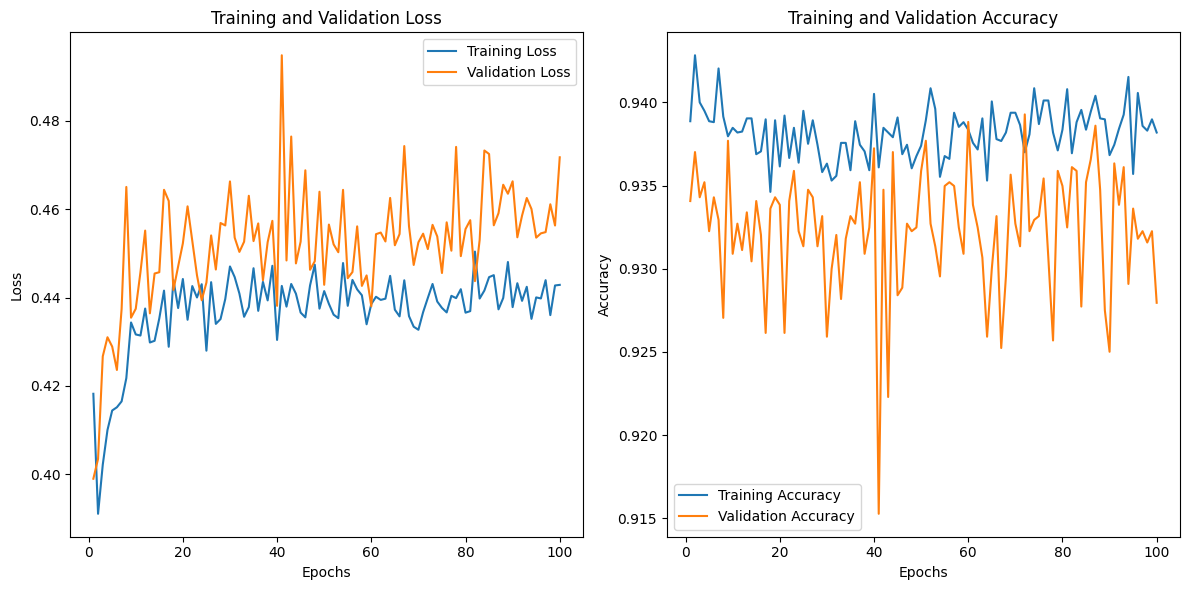

In [25]:
import matplotlib.pyplot as plt

# Variables to store training and validation metrics
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Train for 500 epochs
epochs = 100

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

history = fnnnet.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=64, validation_data=(X_test_tfidf, y_test))


# Extract metrics from the history object
train_accuracies = history.history['accuracy']
train_losses = history.history['loss']
val_accuracies = history.history['val_accuracy']
val_losses = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import classification_report
import numpy as np


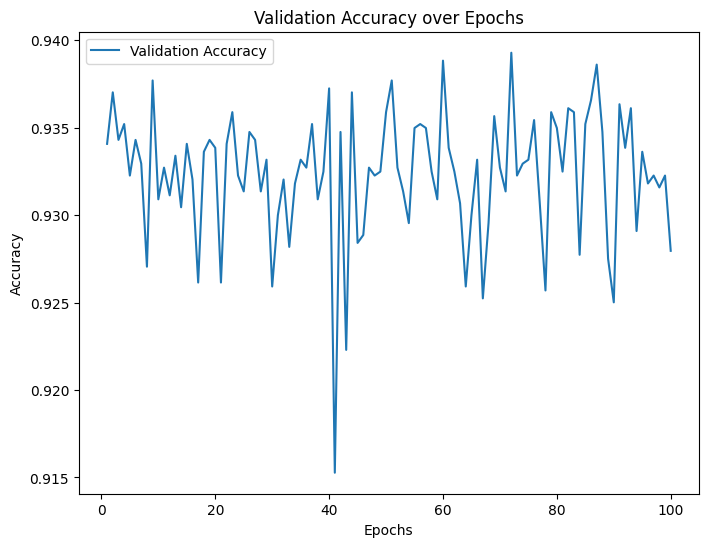

In [27]:
# prompt: give the code for getting validation accuracy for the above model and show it graphically

# Plot the validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [28]:
# prompt: take the input from the user and predict if the article given is true or fake from the trained model

# Get input from the user
user_input = input("Enter the news article: ")

# Call the prediction function
result = predict_news(user_input, fnnnet, vectorizer)
print(f"The news is: {result}")


Enter the news article: Fred Rogers served as a sniper during the Vietnam War and had a large number of confirmed kills. Fred Rogers wore his iconic sweaters to conceal the extensive tattoos on his arms that were acquired while serving in the military.
1/1 [==============================] - 0s 25ms/step
The news is: True News


In [29]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.0 MB/s eta 0:00:00


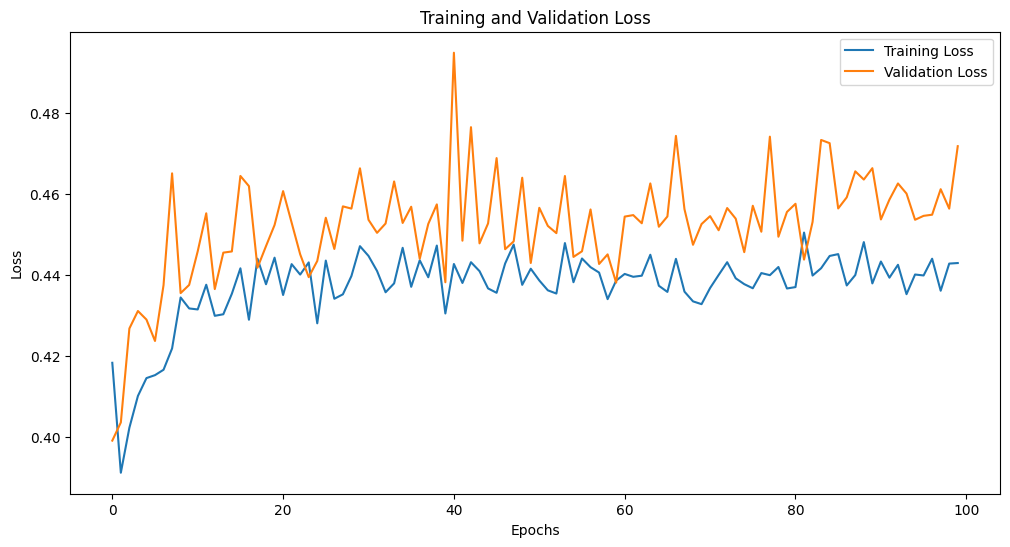

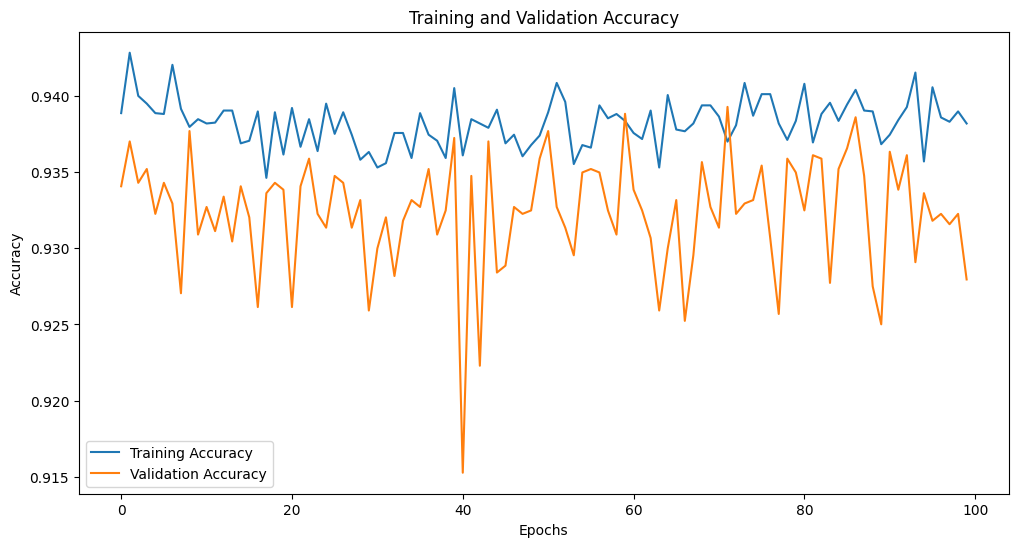

138/138 [==============================] - 0s 2ms/step


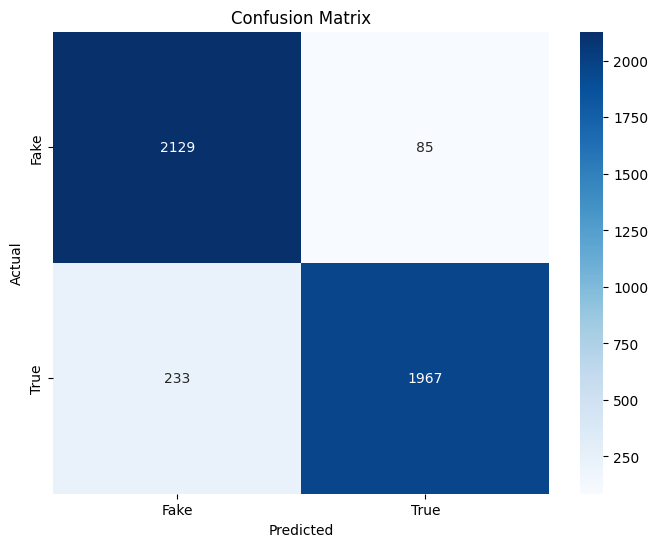

138/138 [==============================] - 0s 2ms/step


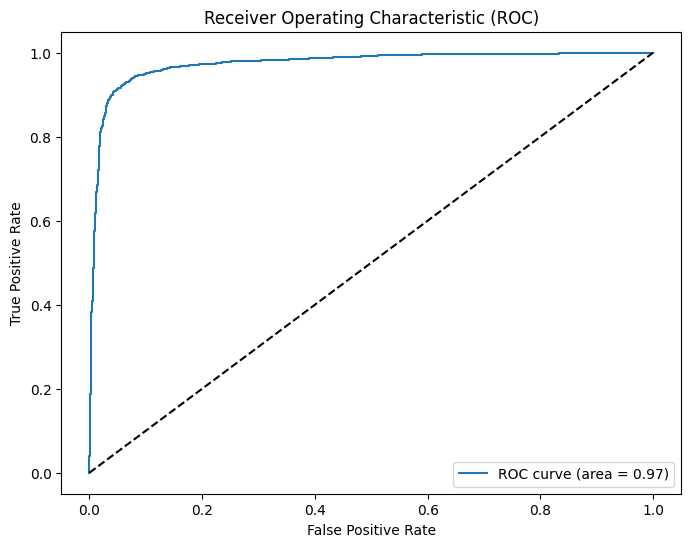

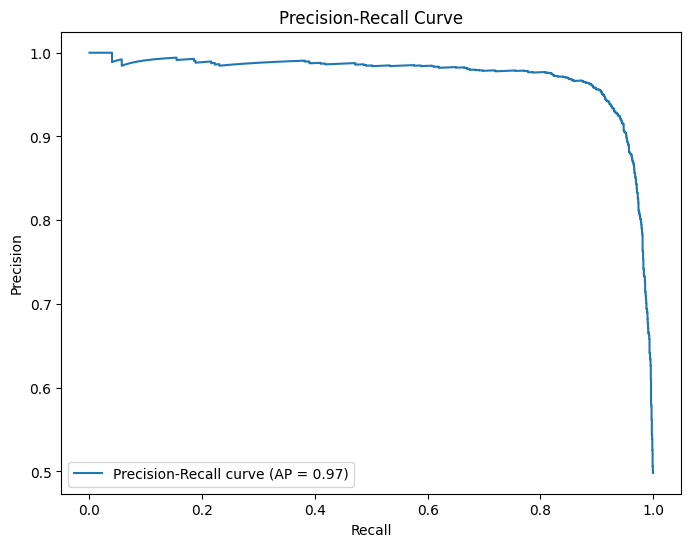

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


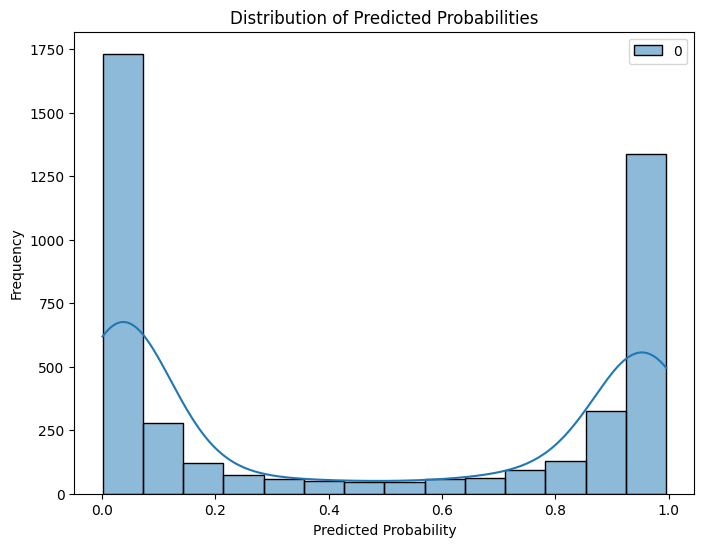

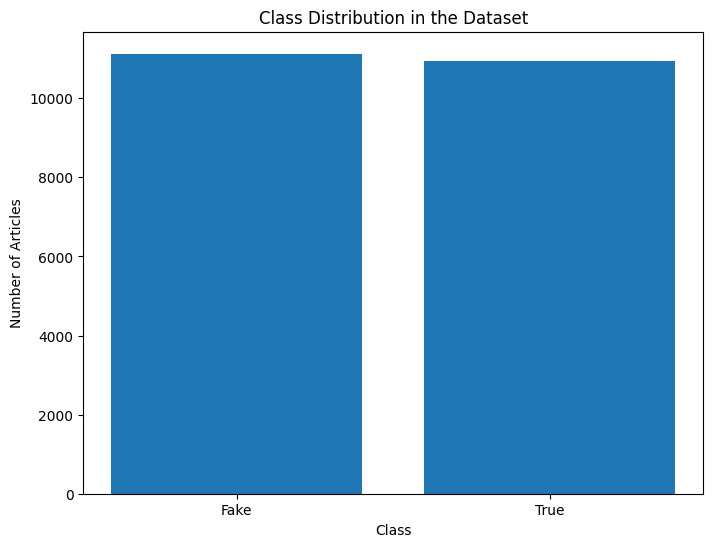

In [30]:
# prompt: give all the codes for all the possible ways for visuals and graphs available for this model

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 2. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 3. Plot Confusion Matrix (requires predictions on test data)
from sklearn.metrics import confusion_matrix

y_pred = (fnnnet.predict(X_test_tfidf) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Plot ROC Curve (requires predictions on test data)
from sklearn.metrics import roc_curve, auc

y_pred_proba = fnnnet.predict(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 5. Plot Precision-Recall Curve (requires predictions on test data)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 6. Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# 7. Bar plot of class distribution in the dataset
class_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(['Fake', 'True'], class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Articles')
plt.title('Class Distribution in the Dataset')
plt.show()

# 8. Word Cloud (requires text preprocessing)
from wordcloud import WordCloud

# Combine all text from true news
true_text = ' '.join(df[df['label'] == 1]['final_news'].tolist())



138/138 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2214
           1       0.96      0.89      0.93      2200

    accuracy                           0.93      4414
   macro avg       0.93      0.93      0.93      4414
weighted avg       0.93      0.93      0.93      4414



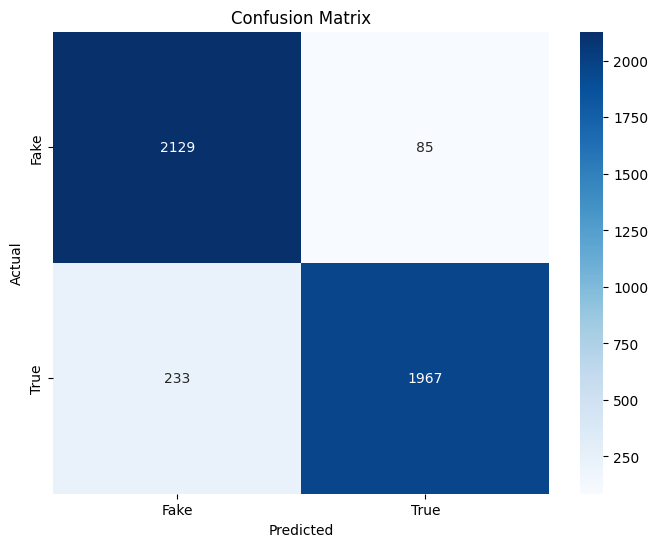

In [31]:
# prompt: classification report and confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_proba = fnnnet.predict(X_test_tfidf)

# Convert probabilities to class labels (0 or 1) using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
?????????????????